# Imports and config

In [1]:
# Import libraries
import os #operating system
import glob # for reading multiple files
from glob import glob
import pandas as pd #pandas for dataframe management
import matplotlib.pyplot as plt #matplotlib for plotting
import matplotlib.dates as mdates # alias for date formatting
import numpy as np # for generating synthetic data

# datetime stuff
from datetime import date
import holidays
import pytz

# pandas settings
pd.set_option('display.max_columns', None)

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


dataPath = '../inverter_data' # set data path
year = 2020


# Read Data

In [2]:
def read_data():
    # read in data and parse dates
    df = pd.read_csv(
        os.path.join(dataPath, 'inverter20.csv'),
        parse_dates=['timestamp_iso', 'datetime'],
        infer_datetime_format=True)
    df.set_index('datetime', inplace=True)
    df.sort_index(inplace=True)

    #convert all columns to numeric
    cols=[i for i in df.columns if i not in ["timestamp_iso", "datetime"]]
    for col in cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # drop timestamp_iso
    df.drop(columns=['timestamp_iso'], inplace=True)

    return df

In [3]:
# read in the data
df = read_data()


In [4]:
df.head(2)

,vdc,idc,pdc,vac,iac,pac,eac,tgr,mod,edc,tto,vbb,ibb,cic,car,soc,vau,iau,pau
datetime,,,,,,,,,,,,,,,,,,,
2020-04-30 21:01:00-03:00,0.0,0.0,0.0,221.0,0.0,0.0,3163870.0,1968.0,1.0,3500281.0,3625.0,271.5,0.0,0.0,100.0,0.0,220.7,0.0,0.0
2020-04-30 21:02:00-03:00,0.0,0.0,0.0,220.2,0.0,0.0,3163870.0,1968.0,1.0,3500281.0,3625.0,274.1,0.0,0.0,100.0,0.0,219.8,0.0,0.0


In [5]:
# print(df[df.vdc.apply(lambda x: isinstance(x, str))])

# Data Processing
## PDC time series

In [6]:
# Check the holidays resolving
brazil_holidays = holidays.Brazil()
for ptr in holidays.Brazil(years = 2020).items():
    print(ptr)

(datetime.date(2020, 1, 1), 'Ano novo')
(datetime.date(2020, 4, 21), 'Tiradentes')
(datetime.date(2020, 5, 1), 'Dia Mundial do Trabalho')
(datetime.date(2020, 9, 7), 'Independência do Brasil')
(datetime.date(2020, 10, 12), 'Nossa Senhora Aparecida')
(datetime.date(2020, 11, 2), 'Finados')
(datetime.date(2020, 11, 15), 'Proclamação da República')
(datetime.date(2020, 12, 25), 'Natal')
(datetime.date(2020, 4, 10), 'Sexta-feira Santa')
(datetime.date(2020, 4, 12), 'Páscoa')
(datetime.date(2020, 6, 11), 'Corpus Christi')
(datetime.date(2020, 2, 26), 'Quarta-feira de cinzas (Início da Quaresma)')
(datetime.date(2020, 2, 25), 'Carnaval')


In [7]:
def create_date_labels(df):
    """ Function to create day labels that could be useful for plotting
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['weekday'] = df.index.weekday
    df['month_name'] = df.index.month_name()
    df['day_name'] = df.index.day_name()

    return df

def custom_resampler(array_like):
    """
    Can you help us? we need to add the data from the pdc column per day and divide by 60 and per month and divide by 60
    """
    return np.sum(array_like) / 60

def extract_day_months(df, col):
    """ Extract months, days and time series index from column in DataFrame
    """
    # extract time series
    ts = df.loc[:,[col]]

    ts_daily = ts.resample('D').apply(custom_resampler)
    days = ts_daily.index.strftime("%Y-%m-%d")
    # ts_daily.set_index(days, inplace=True)

    ts_monthly = ts.resample('M').apply(custom_resampler)
    months = ts_monthly.index.strftime("%Y-%m")
    # ts_monthly.set_index(months, inplace=True)

    return ts, days, ts_daily, months, ts_monthly

def add_holiday(df, col, holidays):
    """ Adds the boolean holiday flag

    Args: 
        ts: time series/dataframe
        col: name of timeseries index
    """
    df.reset_index(inplace=True)
    df[col] = df[col].apply(lambda x: x.date())
    df['holiday'] = df[col].apply(lambda x: x in holidays)
    df.set_index(col, inplace=True)
    df.index = pd.to_datetime(df.index)

    return df


In [8]:
ts, days, ts_daily, months, ts_monthly = extract_day_months(df, 'pdc')

ts_daily = create_date_labels(ts_daily)
ts_monthly = create_date_labels(ts_monthly)

ts_daily = add_holiday(ts_daily, 'datetime', brazil_holidays)
ts_monthly = add_holiday(ts_monthly, 'datetime', brazil_holidays)

In [9]:
# Check
ts_daily.loc[ts_daily['weekday'] < 5] # Weekday
ts_daily.loc[ts_daily['weekday'] >= 5] # Weekend
ts_daily.loc[ts_daily['holiday'] == True] # Holiday

,pdc,year,month,day,weekday,month_name,day_name,holiday
datetime,,,,,,,,
2020-05-01,17516.166667,2020,5,1,4,May,Friday,True
2020-06-11,9093.983333,2020,6,11,3,June,Thursday,True
2020-09-07,0.000000,2020,9,7,0,September,Monday,True
2020-10-12,0.000000,2020,10,12,0,October,Monday,True
2020-11-02,27905.566667,2020,11,2,0,November,Monday,True
2020-11-15,0.000000,2020,11,15,6,November,Sunday,True
2020-12-25,26743.850000,2020,12,25,4,December,Friday,True


# Plotting
## experiment

In [10]:
import seaborn as sns # plotting library
sns.set(rc={'figure.figsize':(11, 4)})

<AxesSubplot:xlabel='datetime'>

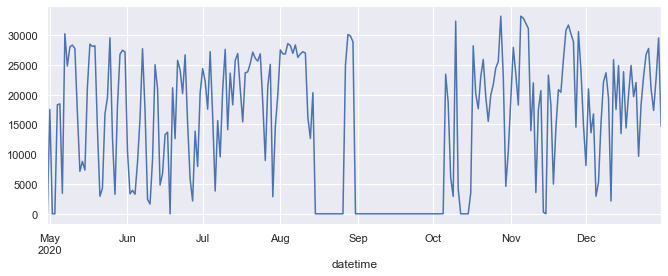

In [11]:
ts_daily['pdc'].plot()

<AxesSubplot:xlabel='datetime'>

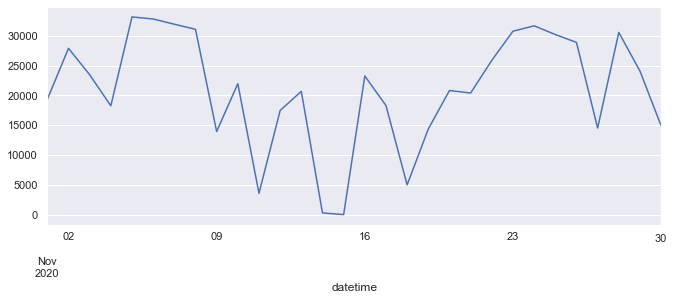

In [12]:
ts_daily.loc[ts_daily['month_name'] == 'November', 'pdc'].plot()

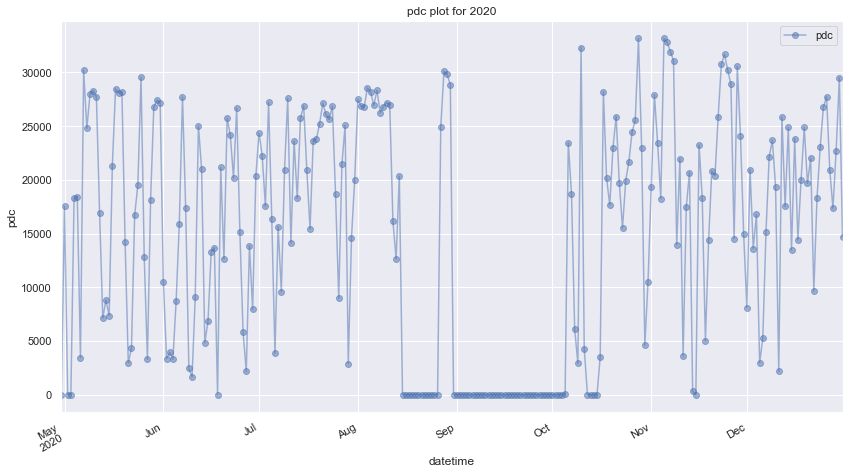

In [13]:
# plot with more customization
cols_plot = ['pdc']
timerange = '2020'
axes = ts_daily[cols_plot].plot(
    marker='o',
    alpha=0.5,
    linestyle='-',
    figsize=(14, 8),
    subplots=True)
for ax in axes:
    ax.set_ylabel('pdc')
    ax.set_title(f'pdc plot for {timerange}')

In [14]:
def plotBox(df, col='pdc', grp='month_name'):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8), sharex=True)
    sns.boxplot(data=df, x=grp, y=col, ax=ax)
    ax.set_label(f'{col}')
    ax.set_title(f'boxplot for year {year}') # year specified in first cell
    ax.set_xlabel('')

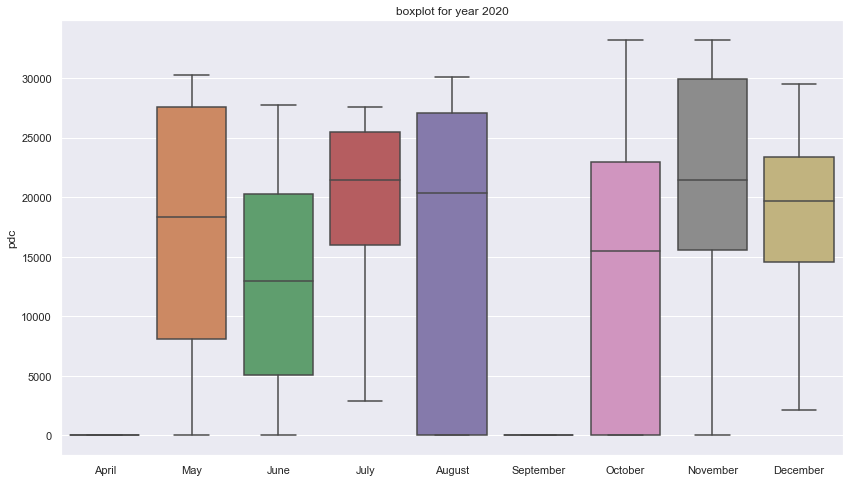

In [15]:
plotBox(ts_daily, 'pdc')

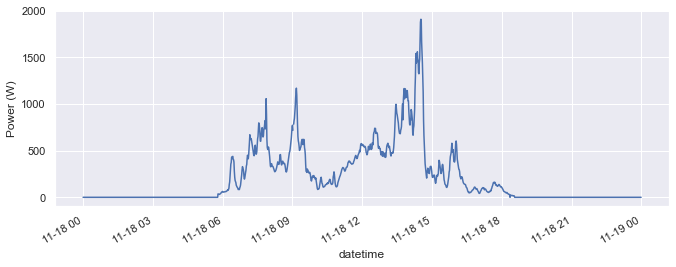

In [16]:
ax = ts.loc['2020-11-18', 'pdc'].plot()
ax.set_ylabel('Power (W)');

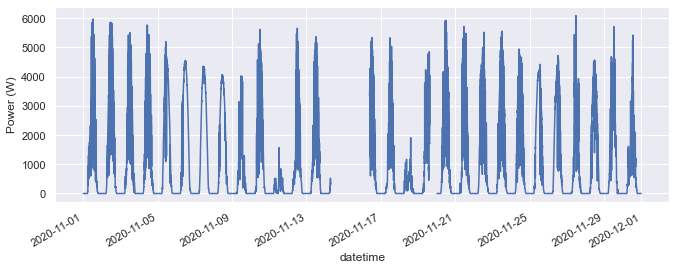

In [17]:
ax = ts.loc['2020-11', 'pdc'].plot()
ax.set_ylabel('Power (W)');

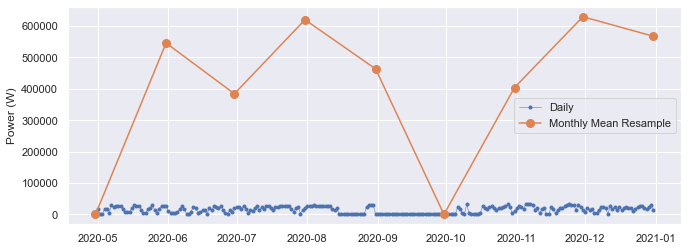

In [18]:
# Start and end of the date range to extract
start, end = '2020-04', '2020-12'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots()
ax.plot(ts_daily.loc[start:end, 'pdc'],
marker='.', linestyle='-', linewidth=0.5, label='Daily')
ax.plot(ts_monthly.loc[start:end, 'pdc'],
marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Power (W)')
ax.legend();

## Charts

# Asks:

- [16:00, 4/7/2021] +55 41 9845-4119: when I went to convert the UTC timezone to America/Sao_Paulo, a datetime column was added to the end of the file

- [16:04, 4/7/2021] +55 41 9845-4119: Can you help us?
we need to add the data from the pdc column per day and divide by 60 and per month and divide by 60 ...Can you help us?
we need to add the data from the pdc column per day and divide by 60 and per month and divide by 60 ... and make a daily chart per hour and a monthly chart per day

- [16:16, 4/7/2021] +55 41 9845-4119: the pac column, we need to add the positive numbers and divide by 60 until 6pm, per day.
We need to save in a new column (Pbat) the sum of the numbers in Pac from 6pm to 9pm.
As of 20/06/08(y-m-d), negative data in Pac must be added and saved in a new column (Pbatc).
We need to make a daily hourly and monthly daily chart.

1) datetime added to end of file ... is this a problem? leaving it for now..
2) group by day and sum the pdc column and divide by 60.
3) group by month and sum and divide by 60
4) plot pdc vs hr. one figure per day
5) plot pdc vs day. one figure per month
